In [1]:
!pip install -q rasterstats
!pip install -q odc-stac -U

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx
import sys
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils
import fsspec
from pathlib import Path


In [3]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
#client = Client(cluster)
#client

In [4]:
import dask_gateway
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=90, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.2bfc128d3bda4266a10d8b4e100977d9/status


In [5]:
gf = gpd.read_file('https://github.com/scottyhq/snotel/raw/main/snotel-sites.geojson')

In [6]:
snotel_gf = gf[gf.isActive==True]
snotel_gf = snotel_gf[(snotel_gf.beginDate<'2015-01-01') & (snotel_gf.endDate>'2022-01-01')]
snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

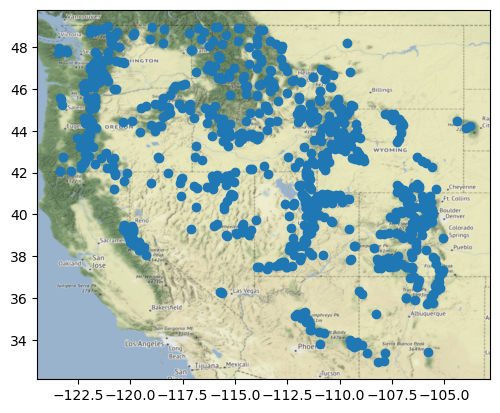

In [7]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [8]:
years = [2015,2016,2017,2018,2019,2020,2021,2022]
#years = [2016,2017,2018,2019,2020,2021,2022]
#years = [2017,2018,2019,2020,2021,2022]
max_swe_years = [f'max_swe_{year}' for year in years]

In [9]:
%%time
my_file = Path("snotel_gf.geojson")
if my_file.is_file():
    snotel_gf = gpd.read_file('snotel_gf.geojson')
else:
    for i,row in snotel_gf.iterrows():
        try:
            snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-02-01',f'{years[-1]}-09-30')]
            dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
        #print(dates)
            if len(dates)==len(years):
                snotel_gf.loc[i,max_swe_years] = dates.values
        except:
            pass
        
        for year in years:
            snotel_gf[f'max_swe_{year}'] = pd.to_datetime(snotel_gf[f'max_swe_{year}']).dt.dayofyear
            
        snotel_gf.to_file("snotel_gf.geojson", driver='GeoJSON')

CPU times: user 87.4 ms, sys: 0 ns, total: 87.4 ms
Wall time: 94.6 ms


In [10]:
code = '679_WA_SNTL'
#code = '475_UT_SNTL'
#code = '395_OR_SNTL'
#code = '811_NV_SNTL'
#code = '1146_UT_SNTL'
#code = '665_NM_SNTL'
#code = '842_CO_SNTL'
#code = '478_WA_SNTL'

snotel_row = snotel_gf[snotel_gf.code==code]

In [11]:
aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{snotel_row.mgrs.values[0]}/runoff_onset_{snotel_row.mgrs.values[0]}_2015_median_40m.tif")

In [12]:
snotel_row_proj = snotel_row.to_crs(aoi.rio.crs)

In [13]:
buffer = 500
snotel_row_proj_buff = gpd.GeoDataFrame(snotel_row_proj,geometry=snotel_row_proj.buffer(buffer))

In [14]:
snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]

In [15]:
snotel_row_proj_buff

code      name  elevation_m  latitude  longitude  county  \
517  679_WA_SNTL  Paradise  1563.624023  46.78265 -121.74765  Pierce   

          state  beginDate    endDate  isActive   mgrs  timeseries  \
517  Washington 1979-10-01 2100-01-01      True  10TES        True   

     max_swe_2017  max_swe_2018  max_swe_2019  max_swe_2020  max_swe_2021  \
517         123.0         111.0         110.0          97.0         110.0   

     max_swe_2022                                           geometry  
517         136.0  POLYGON ((596095.572 5181772.683, 596093.164 5...

In [16]:
# f,ax=plt.subplots(len(years),2,figsize=(12,18),gridspec_kw={'width_ratios': [1, 4]})

# for i,year in enumerate(years):
#     aoi = rxr.open_rasterio(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{snotel_row.mgrs.values[0]}/runoff_onset_{snotel_row.mgrs.values[0]}_{year}_median_40m.tif")

#     snotel_row_proj_buff.boundary.plot(ax=ax[i,0],color='red')
#     aoi.plot(ax=ax[i,0],vmin=80,vmax=200)
#     ctx.add_basemap(ax=ax[i,0], crs=snotel_row_proj_buff.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

#     ax[i,0].set_xlim([snotel_row_proj_buff.total_bounds[0]-500,snotel_row_proj_buff.total_bounds[2]+500])
#     ax[i,0].set_ylim([snotel_row_proj_buff.total_bounds[1]-500,snotel_row_proj_buff.total_bounds[3]+500])
#     ax[i,0].set_title(f'{year}')

#     snotel_data_thisyear = snotel_data['WTEQ'].loc[slice(f'{year}-01-01',f'{year}-12-31')]

#     snotel_data_thisyear.plot(ax=ax[i,1],color='blue')


#    #peak_swe = pd.to_datetime(f'{year*1000}{snotel_row_proj_buff[f'max_swe_{year}']}', format = "%Y%j")
#     ax[i,1].vlines(x=snotel_data_thisyear.idxmax(),ymin=snotel_data_thisyear.min(),ymax=snotel_data_thisyear.max()+snotel_data_thisyear.max()*0.1,linestyle='dashed',color='blue')

# plt.tight_layout()

In [17]:
url = 'https://github.com/scottyhq/mgrs/raw/main/MGRS_LAND.parquet' # Scott created an MGRS parquet file here https://github.com/scottyhq/mgrs
with fsspec.open(url) as file:
    mgrs_gdf = gpd.read_parquet(file)

In [18]:
bbox_gdf = mgrs_gdf[mgrs_gdf.tile==snotel_row_proj_buff.mgrs.values[0]]
resolution = 80
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_odc_pc(bbox_gdf,start_time='2015-01-01',end_time='2022-12-31',resolution=resolution,epsg=f'EPSG:{bbox_gdf.epsg.values[0]}')

In [19]:
extent = snotel_row_proj_buff.centroid.buffer(buffer).total_bounds

In [20]:
ts_ds_extent = ts_ds.sel(x=slice(extent[0],extent[2]),y=slice(extent[3],extent[1]))

In [21]:
%%time 
ts_ds_clip = ts_ds_extent.rio.clip(snotel_row_proj_buff.geometry).compute() # maybe.compute() here

CPU times: user 8.41 s, sys: 478 ms, total: 8.89 s
Wall time: 41 s


In [22]:
classes = [ # page 13 of https://esa-worldcover.s3.amazonaws.com/v100/2020/docs/WorldCover_PUM_V1.0.pdf
#    10, # treecover
    20, # shrubland
    30, # grassland
    40, # cropland
#    50, # built-up
    60, #bare / sparse vegetation
    70, # snow and ice
#    80, # permanent water bodies
    90, # herbaceous wetlands
    95, # mangroves
    100 # loss and lichen
]
worldcover = s1_rtc_bs_utils.get_worldcover(ts_ds_clip)
ts_ds_clip = ts_ds_clip.where(worldcover.isin(classes))

In [23]:
#ts_ds_clip

In [24]:
#ts_ds_clip_group = ts_ds_clip.groupby('sat:relative_orbit').mean(dim=['x','y'])

In [25]:
#ts_ds_clip_group

In [26]:
#ts_ds_clip

[ 13  35  64 115 137]
[ 13  35  64 115 137]
[ 13  35  64 115 137]
[ 13  35  64 115 137]
[ 13  35  64 115 137]
[ 13  35  64 115 137]
[ 13  35  64 115 137]
[ 13  35  64 115 137]


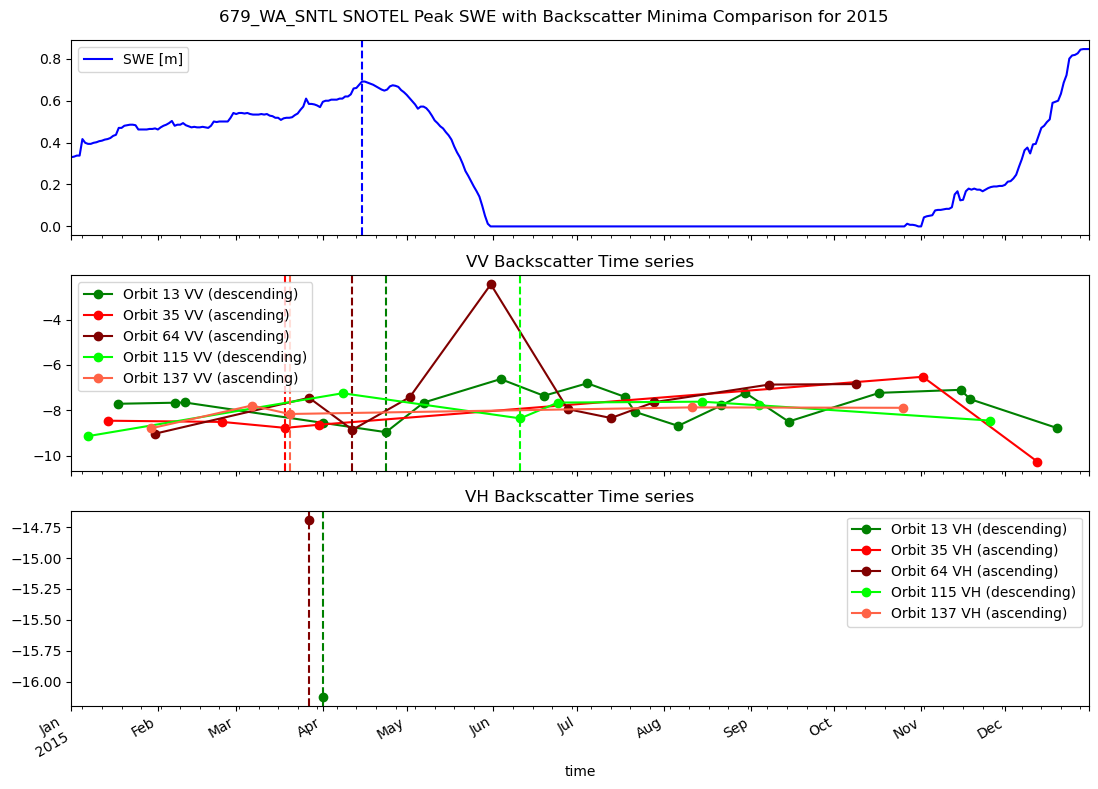

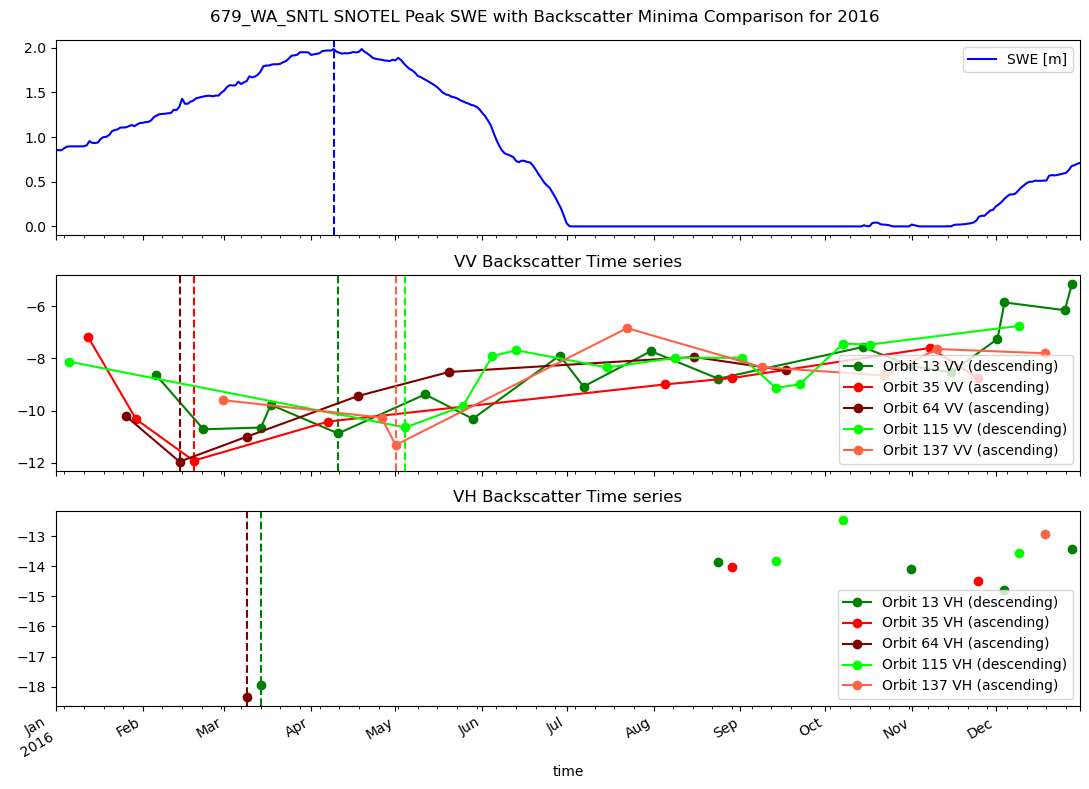

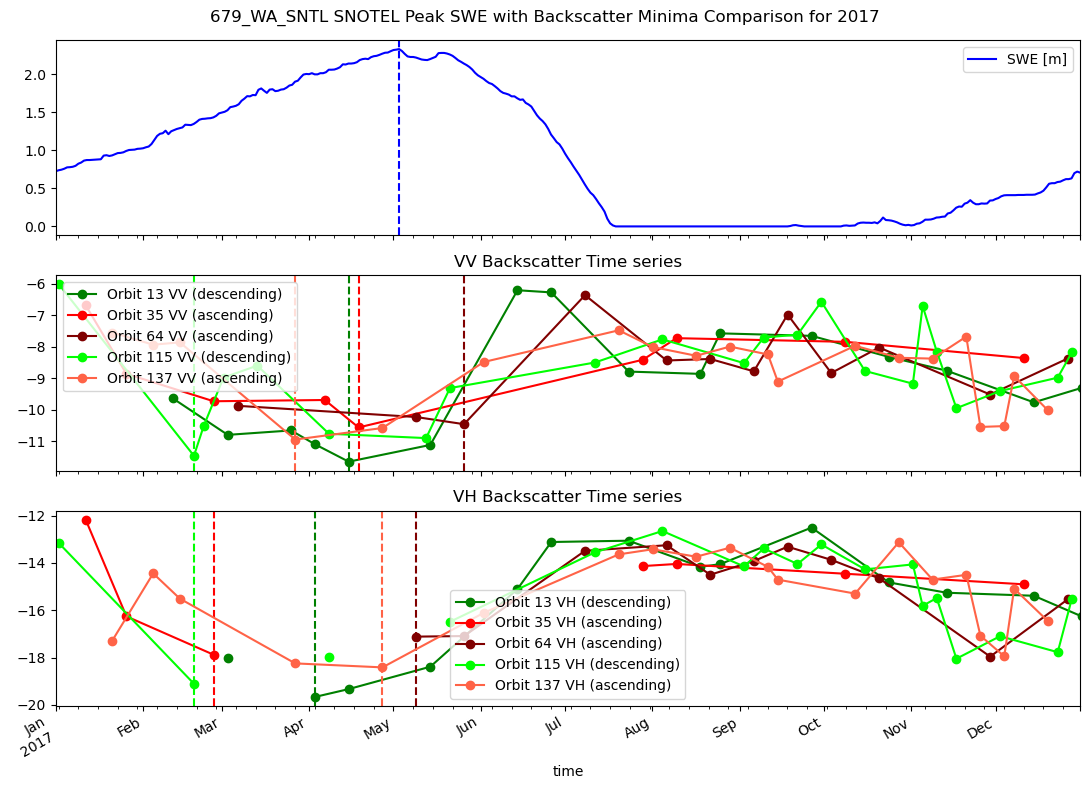

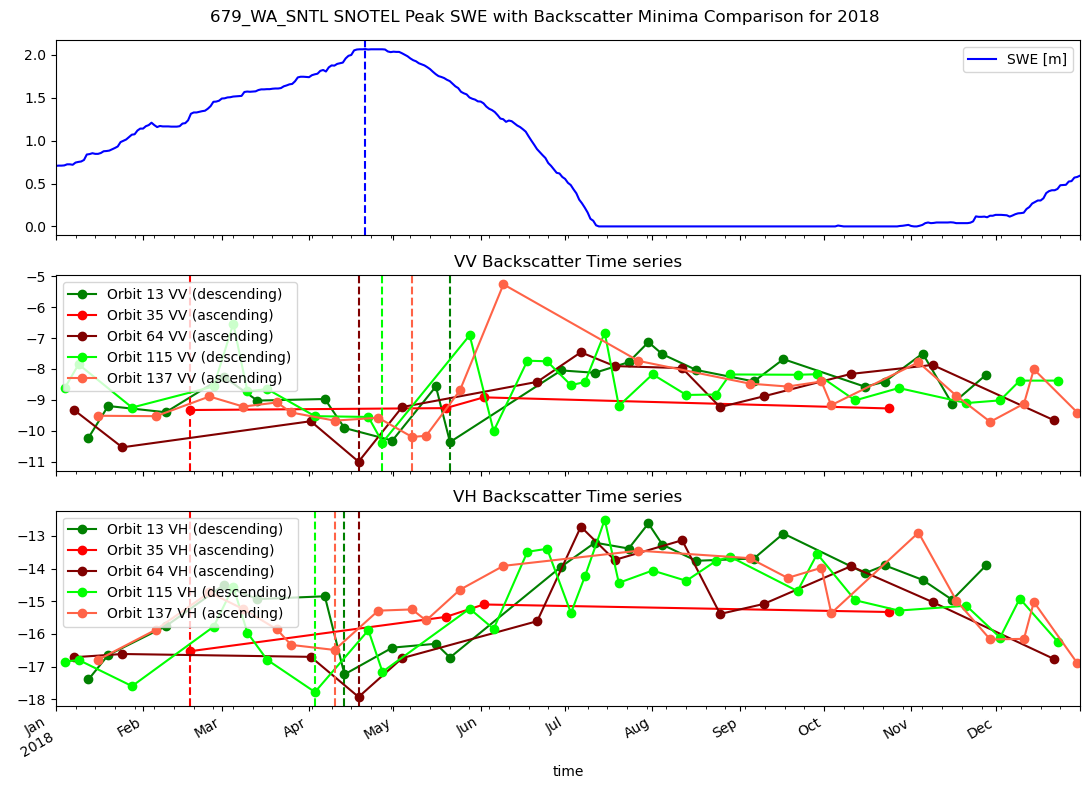

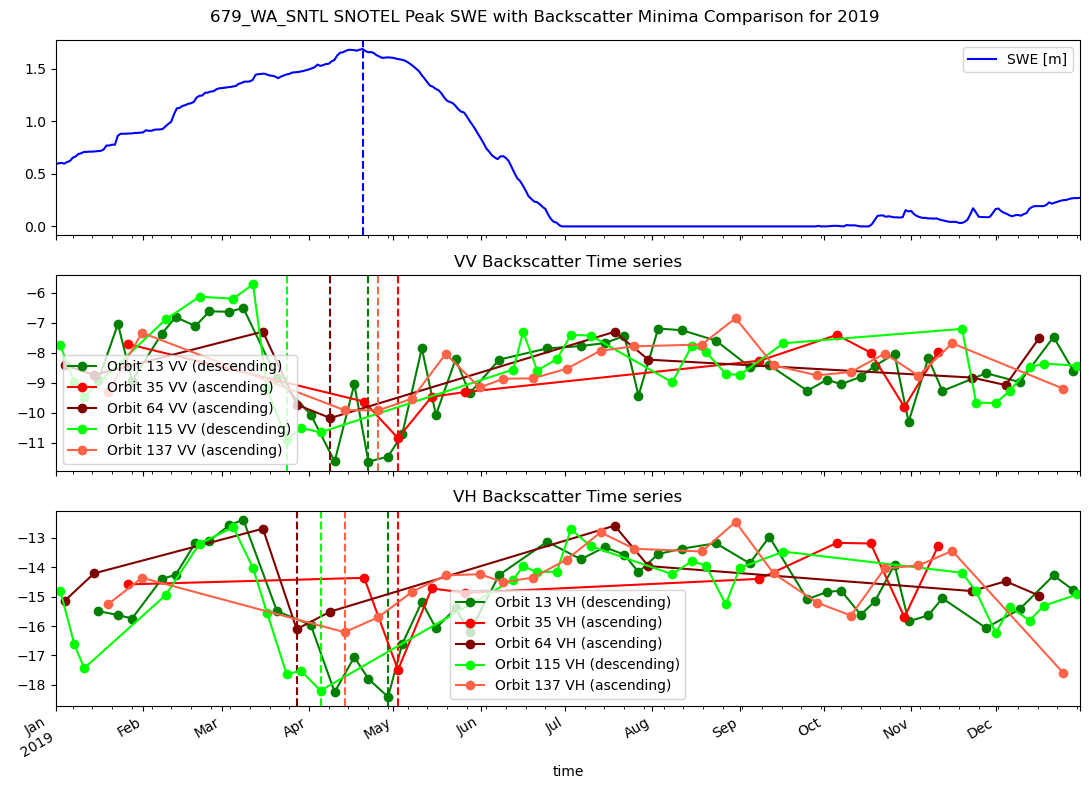

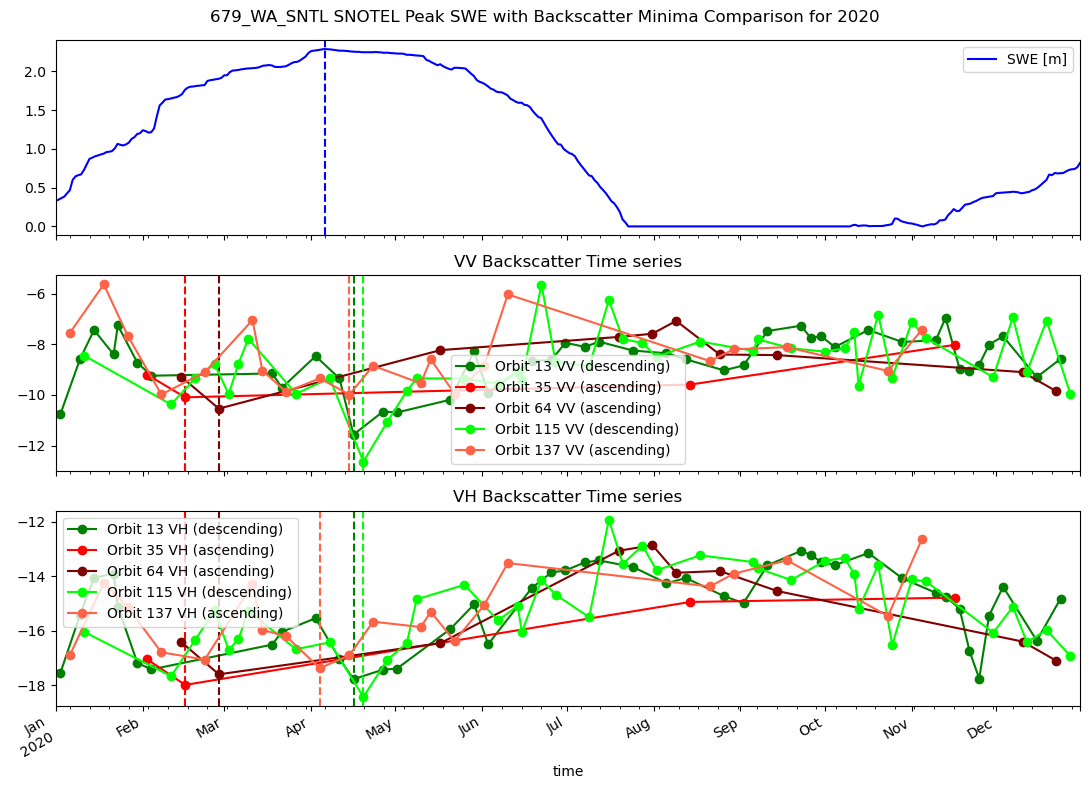

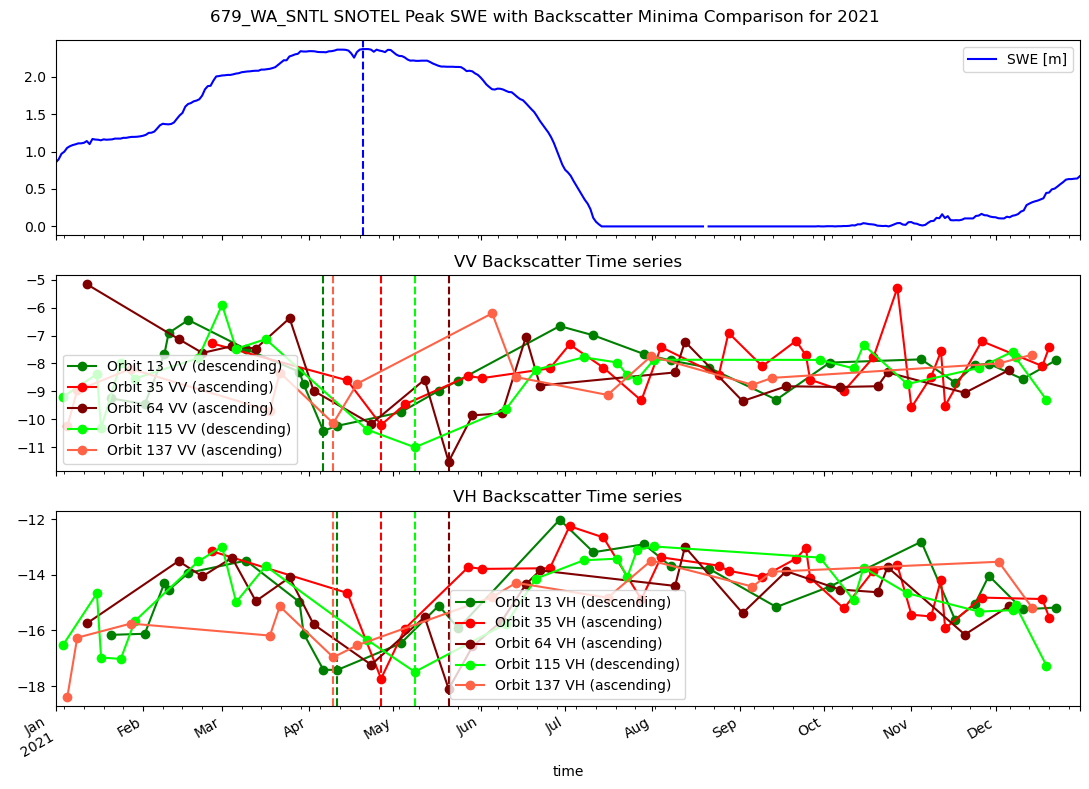

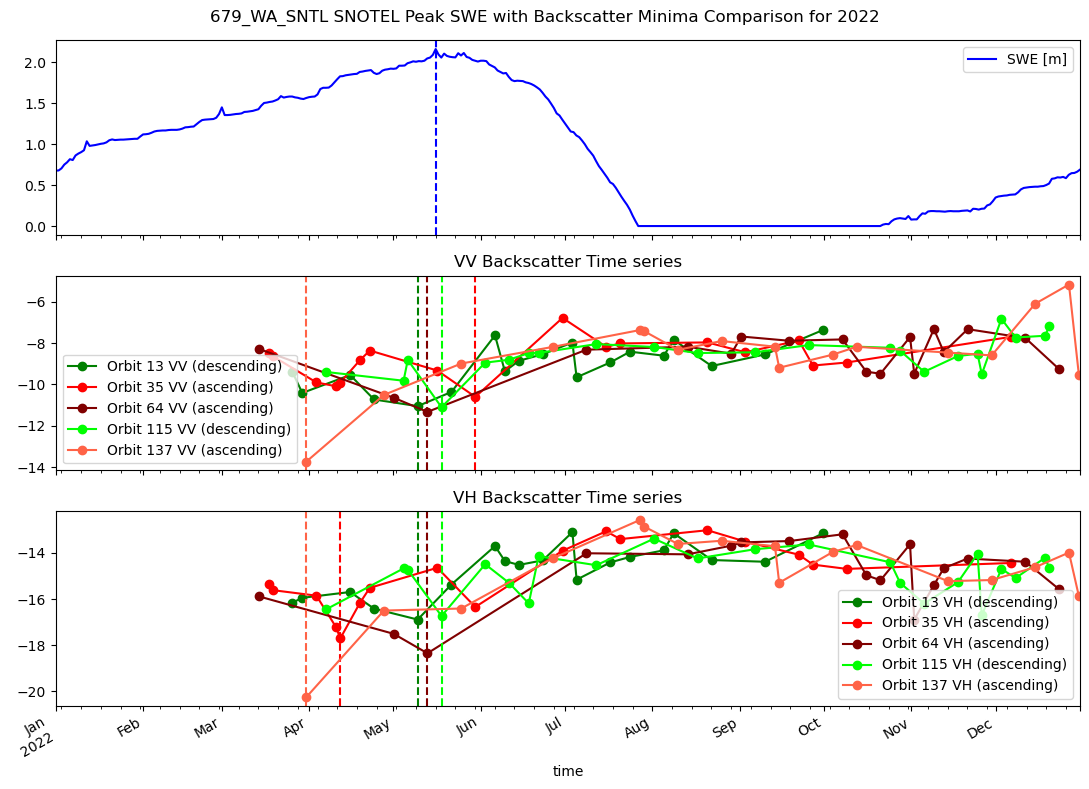

In [27]:
for year in years:
    f,ax=plt.subplots(3,1,figsize=(11,8),sharex=True)
    
    f.suptitle(f'{code} SNOTEL Peak SWE with Backscatter Minima Comparison for {year}')
    colors1 = iter(['red','maroon','tomato','lightcoral','rosybrown'])
    colors2 = iter(['green','lime','yellowgreen','mediumspringgreen','aquamarine'])


    snotel_data_thisyear = snotel_data['WTEQ'].loc[slice(f'{year}-01-01',f'{year}-12-31')]
    snotel_data_thisyear.plot(ax=ax[0],color='blue',label=f'SWE [m]')
    ax[0].legend()
    ax[0].axvline(x=snotel_data_thisyear.loc[slice(f'{year}-02-01',f'{year}-07-31')].idxmax(),linestyle='dashed',color='blue')


    ts_ds_clip_year = ts_ds_clip.loc[slice(f'{year}-01-01',f'{year}-12-31')].dropna('time',how='all')

    orbits = s1_rtc_bs_utils.get_orbits_with_melt_season_coverage(ts_ds_clip_year,num_acquisitions_during_melt_season=1)
    print(orbits)
    ts_ds_clip_year = ts_ds_clip_year[ts_ds_clip_year['sat:relative_orbit'].isin(orbits)]

    for orbit in np.unique(ts_ds_clip_year['sat:relative_orbit']):
        single_orbit = ts_ds_clip_year[ts_ds_clip_year['sat:relative_orbit']==orbit].mean(dim=['x','y'])
        single_orbit_db = 10*np.log10(single_orbit)
        #single_orbit_db = single_orbit

        #color1 = next(colors1)
        #color2 = next(colors2) 

        asc_or_desc = single_orbit['sat:orbit_state'][0]

        if asc_or_desc == 'ascending':
            color = next(colors1)
        else:
            color = next(colors2)

        single_orbit_db.sel(band='vv').plot.line(ax=ax[1],label=f'Orbit {orbit} VV ({asc_or_desc})',linestyle='-',marker='o',color=color)
        single_orbit_db.sel(band='vh').plot.line(ax=ax[2],label=f'Orbit {orbit} VH ({asc_or_desc})',linestyle='-',marker='o',color=color)

        ax[1].axvline(x=single_orbit_db.sel(band='vv').loc[slice(f'{year}-02-01',f'{year}-07-31')].idxmin().values,linestyle='dashed',color=color) #,ymin=-12,ymax=-4,
        ax[2].axvline(x=single_orbit_db.sel(band='vh').loc[slice(f'{year}-02-01',f'{year}-07-31')].idxmin().values,linestyle='dashed',color=color) #,ymin=-17,ymax=-12 #using axvline gives seperate ticks
    ax[1].legend()
    ax[2].legend()

    ax[1].set_title('VV Backscatter Time series')
    ax[2].set_title('VH Backscatter Time series')


        #peak_swe = pd.to_datetime(f'{year*1000}{snotel_row_proj_buff[f'max_swe_{year}']}', format = "%Y%j")

    plt.tight_layout()